## Projeto 3 - Machine Learning

**Caio Emanuel Rhoden - RA 214129**</br>
**Gabriel De Freitas Garcia -RA 216179**

Este projeto tem como objetivo treinar e mostrar o resultados de um agente de pacman que joga sozinho, sendo divido em duas aprtes: Modelo Evolucionário e Aprendizado por Reforço. A primeira parte feita pelo aluno Caio e a segunda pelo aluno Gabriel, com a discussão final dos resultados sendo feita de forma colaborativa

In [1]:
%cd ../search/search
#! python pacman.py --layout originalClassic

C:\Users\Acer\projects_MachineLearning\project3_ra214129_ra216179\search\search


In [2]:
from pacman import runGames,readCommand
from game import Agent, Directions
from util import manhattanDistance, PriorityQueue
import random
import numpy as np
import json
import statistics
import matplotlib.pyplot as plt
import operator

In [3]:
random.seed(7)

### Sumário

* [Modelo Evolucionário](#title1)
* [Cromossomo](#title2)
* [Agente Evolucionário](#title3)
* [Inicialização rnadômica](#title4)
* [Função de Aptidão](#title12)
* [Seleção](#title5)
* [Crossover](#title6)
* [Mutação](#title7)
* [Função de treinamento](#title8)
* [Treinamento Evolucionário - Labirinto Pequeno](#title9)
* [Treinamento Evolucionário - Labirinto Médio](#title10)
* [Treinamento Evolucionário - Labirinto Original](#title11)
* [Aprendizado por Reforço](#title13)
* [Modelo](#title14)
* [Treinamento](#title15)
* [Execução](#title16)
* [Avaliação - Small Classic](#title17)
* [Avaliação - Medium Classic](#title18)
* [Avaliação - Original Classic](#title19)
* [Agente Pacman Aleatório](#title20)
* [Conclusão](#title21)

## Parte I - Modelo Evolucionário <a name="title1"/>

A ideia inicial era tentar fazer um Programa Genético para buscar os resultados do pacman, para isso tentei fazer um programa baseado em um cromossomo com uma PriorityQueue, estrutura de dados vindas na engine do jogo, que definiria a ordem das ações para diferentes situações de jogo (comida ao lado, comida próxima e em zona de perigo), com um array definindo a ordem de priridade do que se olhar primeiro.

Todavia apesar de existir progresso o algoritmo não convergia, até tinha progresso em resultados mas chegava em um certo numero de gerações que ele não tinha mais evolução. Foi aplicada uma série de modificações, como a adição de um status voltado para a capsulas, ainda assim não adiantou muito. Tendo em visto o baixo progresso foi necessário pivotar a ideia e "mudar" um pouco a regra de como o programa funcionava

A partir da leitura dos artigos sugeridos e interação com alguns colegas pareceu fazer sentido dar um passa para trás, simplificando a estrutura mas buscando manter ainda o que era pretendido: comer comida quando tiver ao lado, buscar a comida mais próxima quando nçao tiver nenhuma e não morrer para os fantasmas. Tendo em vista esse objetivo a melhor opção pareceu ser mudar para um algoritmo genético e regrar menos o agente

### Cromossomo <a name="title2"/>

A estrutura de cromossomo é bem simples, um array composto por 4 valores que representam
as respectivas ações:
- Comer comida próxima
- Se aproximar da comida
- Fantasma próximo
- Se aproximar de fantasma

Eles são criados a aprtir da função abaixo, que retorna um vetor com 4 valores variando de -10 a 10

In [4]:
def create_random_chromossome():
    
    #array created to stablish the six states that will define the actions:
    # - has food
    # - get near to food (if not has food in the adjascents)
    # - has ghost
    # - get away from ghost (if not has ghost in the adjascents)
    
    chromossome = [random.randrange(-10, 10) for i in range(4)]
    
    return chromossome

In [5]:
create_random_chromossome()

[0, -6, 2, -9]

### Agente <a name="title3"/>

O agente é uma representação do que é usado pelo jogo, ele é iniciado com um cromosso e quando ele é chamado para a primeira ação ele retorna o numero de comidas no labirinto

Ele possui o método tomador de ação (getAction) que pega a possição atual do Pacman e as suas possiveis direções, para cada uma dessas direções é verificado se ele se encaixa em cada uma das situações dos valores do cromossomo, caso ele se encaixe, o valor dessa situação é acrescentado para o "valor" da direção, no fim, a direção com o maior valor é a que será tomada

Com isso o objetivo é que o pacman desenvolva um valor alto para se aproximar de comida e um valor baixo para se aproximar de fantasmas

In [6]:
## Define some rules for the pacman agent

class SingleLookAgent(Agent):
    
    ## Recevies the chromosome, the danger distance from ghosts and initialize de total food of the maze
    
    def __init__(self, chromo, index=0):
        super().__init__(index)
        self.chromossome = chromo
        self.foodTotal = 0

    def getAction(self, state):
        if state.getNumFood() > self.foodTotal:
            self.foodTotal = state.getNumFood()
        
        pacman_pos = state.getPacmanPosition()
        legalActions = state.getLegalPacmanActions()
        directionsValues = {}
        
        foodAdjascents = False
        for i in [-1, 1]:
            if state.hasFood(pacman_pos[0]+i, pacman_pos[1]) or state.hasFood(pacman_pos[0], pacman_pos[1]+i):
                foodAdjascents = True
                break
        
        for i in legalActions:
            directionsValues[i] = 0
            if i == "North":
                position = (pacman_pos[0], pacman_pos[1]+1)
            elif i == "South":
                position = (pacman_pos[0], pacman_pos[1]-1)
            elif i == "West":
                position = (pacman_pos[0]-1, pacman_pos[1])
            elif i == "East":
                position = (pacman_pos[0]+1, pacman_pos[1])
            else:
                position = (pacman_pos[0], pacman_pos[1])
            
            #first coeficient
            if state.hasFood(position[0], position[1]):
                directionsValues[i] += self.chromossome[0]
            
            #second coeficient
            elif not foodAdjascents and len(state.getFood().asList()) > 0:
                
                currentDistFood = min([manhattanDistance(pacman_pos , j) for j in state.getFood().asList()])
                directionDistFood = min([manhattanDistance(position , j) for j in state.getFood().asList()])
                
                if directionDistFood < currentDistFood:
                    directionsValues[i] += self.chromossome[1]
            
            #third coeficient
            if position in state.getGhostPositions():
                 directionsValues[i] += self.chromossome[2]
            
            #fourth coeficient
            else:
                currentDistGhost = min([manhattanDistance(pacman_pos , j) for j in state.getGhostPositions()])
                directionDistGhost = min([manhattanDistance(position , j) for j in state.getGhostPositions()])
                
                if directionDistGhost < currentDistGhost:
                    directionsValues[i] += self.chromossome[3]
        
        return max(directionsValues.items(), key=operator.itemgetter(1))[0]
        
            
    def serialize(self,path):
        try:
            f = open(path,"w")
            json.dump(self.chromossome,f)
            f.close()
        except:
            raise Exception("You've got an error")

    def desserialize(self,path):
        try:
            f = open(path,"r")
            self.chromossome = json.load(f)
            f.close()
        except:
            raise Exception("You've got an error")
    

In [7]:

agente = SingleLookAgent(create_random_chromossome())
args = readCommand(['-q', '--pacman', 'GreedyAgent', '-l', 'smallClassic','-n', '1'])
args['pacman'] = agente
a = runGames(**args)
print(a)


In [8]:
print(a[0].state.isWin())

False


### Inicialização Randômica <a name="title4"/>

Com essa função é criada uma população aleatória (vetor de cromossomos) de tamanho n

In [9]:
def randomPopulation(size):
    population = []
    for i in range(size):
        population.append(create_random_chromossome())
        
    return population

In [10]:
randomPopulation(2)

[[1, -10, 4, 1], [-5, 9, -7, 5]]

### Função de Aptidão <a name="title12"/>

Aqui vamos estabelecer como condição de sucesso para os individuos, inicialmente podemos estabelecer como critério de sucesso a vitória para os tabuleiros, e para avaliar a aptidão dos individuos até lá, a pontuação total obtida. Como o score pode flutuar bastante com a ingestão das capsulas e não havia nada de fácil acesso na engine para lidar com a situação dos fantasmas vulneráveis, foi optado por ter como objetivo a vitória no tabuleiro, indiferente do score, dessa forma a nossa aptidão é medida pela quantidade de comidas ingeridas pelo agente

Por meio da função abaixo, que recebe o total de comidas no tabuleiro -1 (comida sobre onde o pacman iniciou em cima) e o resultado do jogo, no fim para conseguir as comdias ingeridas é feito total do tabuleiro - número de comidas que sobraram ao final do jogo + 1

In [11]:
def fitnessFunction(gamesResult, totalFood):
    gamesScores = [(totalFood - i.state.getNumFood() + 1) for i in gamesResult]
    avgScore = statistics.mean(gamesScores)            
    return(avgScore)

### Seleção <a name="title5"/>

Para seleção aplicaremos o método de roleta, nele quanto maior a aptidão que um individuo conseguiu maior a chance de ser escolhido, mas ele ainda dá espaço para que individuos não tão aptos possam ser escolhidos (algo mais limitado no formato de campeonato), o que é importante para garantir a variabilidade genética

Essa função por si só é relativamente simples, ela pega a quantidade de comidas ingeridas para cada e individuo e a soma total dessa quantidade, cria um vetor em que vai marcando o limite de cada individuo nessa soma e por fim sortei aleatoriamente um valor entre 1 e a soma acumulado, e o individuo que tiver nessa marcação será adicionado a um vetor de selecionados

In [12]:
def selection(layout, population, n, n_games):
    selected = []
    popScores = []
    for i in range(len(population)):
        agente =  SingleLookAgent(population[i])
        args = readCommand(['-q', '--pacman', 'Agent', '-g', 'DirectionalGhost','-l', layout,'-n', str(n_games)])
        args['pacman'] = agente
        popScores.append(runGames(**args))
    acumulatedScores = []
    fitnessScores = [fitnessFunction(i, args['pacman'].foodTotal) for i in popScores]
    for i in range(len(popScores)):
        if i == 0:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal))
        else:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal)+acumulatedScores[-1])
    
    totalScore = sum(fitnessScores)
    for i in range(n):
        rand = random.randrange(1,int(totalScore))
        for j in range(0, len(fitnessScores)):
            if rand <= acumulatedScores[j]:
                selected.append(population[j])
                break
        
    return selected, popScores, fitnessScores

In [13]:
pop = randomPopulation(3)
print(pop)
selection('smallClassic',pop,1, 3)

[[-9, -4, -1, -6], [-3, 2, 2, 5], [-8, -5, 4, 2]]


([[-3, 2, 2, 5]],
 [[<game.Game at 0x21024206dc0>,
 [1, 3, 1])

### Crossover <a name="title6"/>

No crossover é onde vamos utilizar os individuos selecionados anteriormente, essa função vai receber os pais (individuos selecionados), a taxa de crossover (quantos % da nova geração será por crossover) e o tamanho da nova geração. A % que não se encaixar como crossover vai ser apenas uma duplicação dos pais.

Para realizar o crossover são selecionados dois cromossomos pais aleatoriamente, depois são selecionadas dois indices de sepração, o primeiro entre 0 e 2, e o segundo entre o primeiro e 3. Dessa forma o novo cromossomo vai ser formado por três segmentos, o primeiro e o terceiro vindo do primeiro pai (menor ou igual ao primeiro indice e maior que o segundo indice), e o segundo do segundo pai (entre o primeiro e segundo indice)

In [14]:
def reproduction(parents, rate, newGenSize):
    newGen = []   
    for j in range(int(rate*newGenSize)//1):
        
        
        p1 = random.randrange(len(parents))
        p2 = p1
        while p2 == p1:
            p2 = random.randrange(len(parents))
        
        parent1 = parents[p1]
        parent2 = parents[p2]
        
        sep1 = random.randrange(0, 2)
        sep2 = random.randrange(sep1+1, 3)
        
        
        new_gene = create_random_chromossome()
        
        for i in range(4):
            if i <= sep1:
                new_gene[i] = parent1[i]
            elif i > sep1 and i <= sep2:
                new_gene[i] = parent2[i]
            else:
                new_gene[i] = parent1[i]
        
        newGen.append(new_gene)
    
    
    for i in range(newGenSize - int((rate*newGenSize)//1)):
        newGen.append(parents[random.randrange(len(parents))])
    
    return newGen
    

In [15]:
example = randomPopulation(2)
print(example)
print()
print()
print(reproduction(example, 1, 2))

[[3, 6, 2, 0], [3, -4, 1, 0]]


[[3, -4, 1, 0], [3, 6, 1, 0]]


### Mutação <a name="title7"/>

A mutação é um elemento que vai nos garantir também a variabilidade genética entre os membros da nova geração, essa função recebe a população da nova geração e a taxa de mutabilidade

A mutação é feita por um simples swap dentro de um cromossomo, trocando de valor os arrays de prioridades de ação. Isso será feito para a % da população passada pela taxa.

In [16]:
def mutation(population, rate):
    
    population_len = [i for i in range(len(population))]
    mutated = random.sample(population_len, int((rate * len(population))// 1))
    
    
    for i in mutated:
        mut_1 = random.randrange(4)
        mut_2 = mut_1
        while mut_1 == mut_2:
            mut_2 = random.randrange(4)
        saved = population[i][mut_1]
        population[i][mut_1] = population[i][mut_2]
        population[i][mut_2] = saved

    return population 
        
        

In [17]:
example = randomPopulation(3)
print(example)
print(mutation(example,0.5))

[[-9, -5, -2, -6], [3, -2, 2, -6], [7, 6, 8, 5]]
[[-9, -5, -2, -6], [3, -2, 2, -6], [8, 6, 7, 5]]


### Função de treinamento <a name="title8"/>

Essa função sintetísa o treino do modelo a partir da abordagem de algoritmo genético desenvolvida acima. Incialmente é criada uma população inicial aleatória, depois é aplicado um for, limitado ao número máximo de gerações desejadas, dentro selecionamos os pais e aplicamos o crossover e mutação. Tendo feito isso teremos uma nova população de tamanho n em mãos.

Para cada população vamos coletar a apltidão máxima, a aptidão média e o score médio (isso antes de gerar uma nova) dessa forma podendo acompanhar mais claramente a progressão do nosso algoritmo.

Além disso teremos como critério de parada, além do número de gerações, a % de vitórias na geração, se ele atingit pelo menos 80% já será considerado um bom agente

In [18]:
def train(layout, maxGen=1, populationSize=1, selectionSize=1, newGenSize=1,  mutationRate=0.05, 
          crossoverRate=1, n_games=1):
    avgFitnessScores = []
    maxFitnessScores = []
    avgPacmanScores = []
    totalWins = 0
    population = randomPopulation(populationSize)
    for i in range(maxGen):
        winsThisGen = 0
        pacmanScores = []
        newPopulation = []
        parents, gamesResult, scores = selection(layout, population, selectionSize, n_games)
        newGen = reproduction(parents, crossoverRate, newGenSize)
        cutOffScore = sorted(scores)[populationSize-newGenSize]
        for j in range(populationSize):
            if scores[j] < cutOffScore:
                newGene = newGen.pop()
                newPopulation.append(newGene)
            else:
                newPopulation.append(population[j])
        for g in gamesResult:
            for j in g:
                pacmanScores.append(j.state.getScore())
                if j.state.isWin():
                    winsThisGen += 1
        
        totalWins += winsThisGen
        maxFitnessScores.append(max(scores))
        avgFitnessScores.append(statistics.mean(scores))
        avgPacmanScores.append(statistics.mean(pacmanScores))
        population = mutation(newPopulation, mutationRate)
        if i % 1000 == 0:
            print(f"Best Fitness Score Gen {i}: {max(scores)}")
            print(f"Total Wins Gen {i}: {totalWins}")
        if winsThisGen >= populationSize*0.25:
            print("Indice bom de vitórias")
            break
    
    best_ind = population[scores.index(max(scores))]
    f, axarr = plt.subplots(1,3)
    axarr[0].plot(avgFitnessScores)
    #axarr[0].set_xscale('log')
    axarr[1].plot(maxFitnessScores)
    #axarr[1].set_xscale('log')
    axarr[2].plot(avgPacmanScores)
    #axarr[2].set_xscale('log')
    f.set_size_inches(18, 5)
    plt.show()    
        
    print(f"Best Fitness Score Gen {i}: {max(scores)}")
    print(f"Total Wins Gen {i}: {totalWins}")
    return population, best_ind
                

Best Fitness Score Gen 0: 21
Total Wins Gen 0: 0


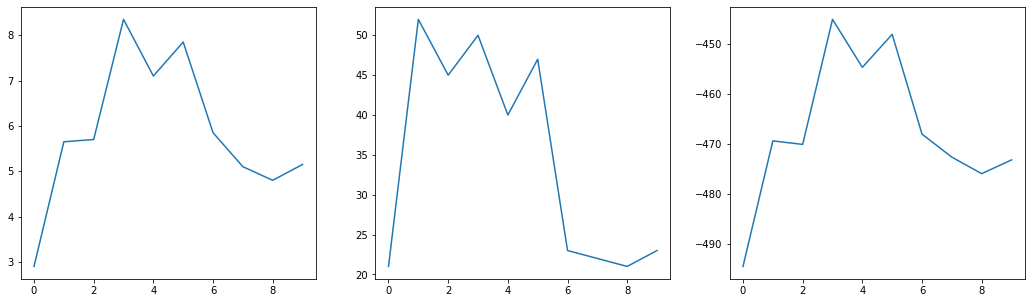

Best Fitness Score Gen 9: 23
Total Wins Gen 9: 0


In [19]:
pop, best_ind = train('smallClassic',maxGen=10, populationSize=20, selectionSize=3, newGenSize=18)

In [23]:
#graphic show
best_agent = SingleLookAgent(best_ind)
args = readCommand(['--pacman', 'GreedyAgent','-l', 'smallClassic','-n', '1'])
args['pacman'] = best_agent
runGames(**args)

### Treinamento -  Small Classic <a name="title9"/>

Antes de começar nosso treinamento definitivo para o labirinto pequeno vamos explorar um pouco a variação de 3 parâmetros. O primeiro vai fazer o método de replacement, incialmente foi pensado em implementar um replacement parcial, visando buscar uma evolução com uma certa estabilidade ao longo das gerações, mas nada mais justo que fazer uma comparação entre os três métodos possiveis de replacmenete: total, elitista e parcial

Best Fitness Score Gen 0: 51
Total Wins Gen 0: 0


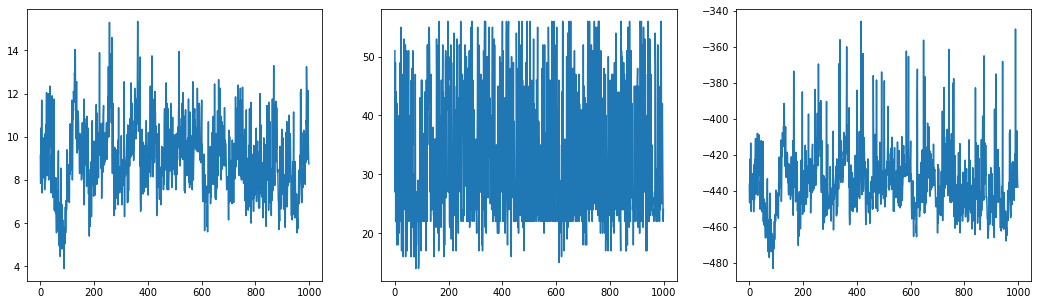

Best Fitness Score Gen 999: 24
Total Wins Gen 999: 31


In [21]:

pop, best_ind_total = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=20,
                            mutationRate=0.05, 
                            crossoverRate=0.9, 
                            n_games=1)

Best Fitness Score Gen 0: 46
Total Wins Gen 0: 0


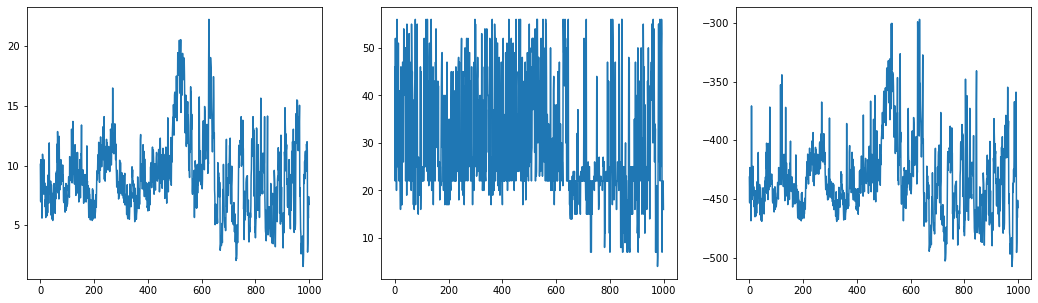

Best Fitness Score Gen 999: 16
Total Wins Gen 999: 26


In [22]:

pop, best_ind_elit = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=19,
                            mutationRate=0.05, 
                            crossoverRate=0.9, 
                            n_games=1)

Best Fitness Score Gen 0: 22
Total Wins Gen 0: 0


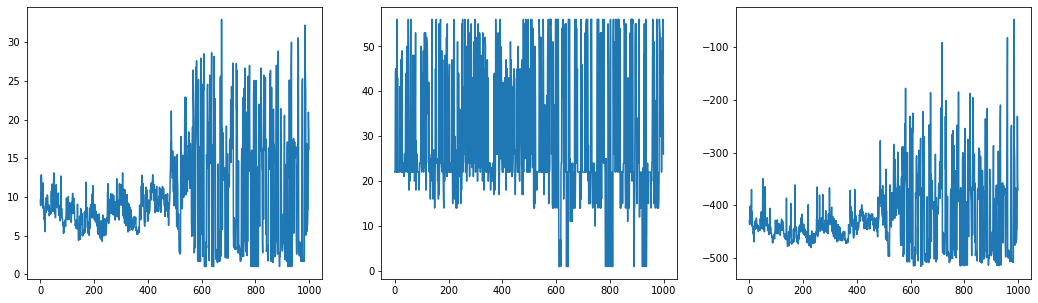

Best Fitness Score Gen 999: 26
Total Wins Gen 999: 86


In [23]:

pop, best_ind_parcial = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.05, 
                            crossoverRate=0.9, 
                            n_games=1)

A partir dessa comapração pudemos ver como se desenvolveramd e formas bem diferentes por conta das técnicas de replacemente, o totalse manteve regularmente constante, o elitista apesar de ter uma curva de crescimento interessante depois de um certo número de gerações começou a oscilar mais para resultados não tão bons, e por fim, o melhor desempenho venho do replacement aprcial, que apesar de ter ainda uma oscilação de resultados considerável atingiu números impressionantes

Estamos ciente que os resultados podem divergir bastante por conta de suas inicializações e também pelos outros parâmetros já colcoados inicialmente, mas acreditamos que com mil amostras possa ser um começo para entender o comportamento das diferentes configurações de treinamento e possibilitando tentar chegar em uma relativamente boa

Agora vamos buscar variar um hiperparâmetro diferente, o crossover rate, nos casos acima ele foi definido com 0.9 mas vamos buscar observar como ele pode impactar os nossos resultados

Best Fitness Score Gen 0: 24
Total Wins Gen 0: 0


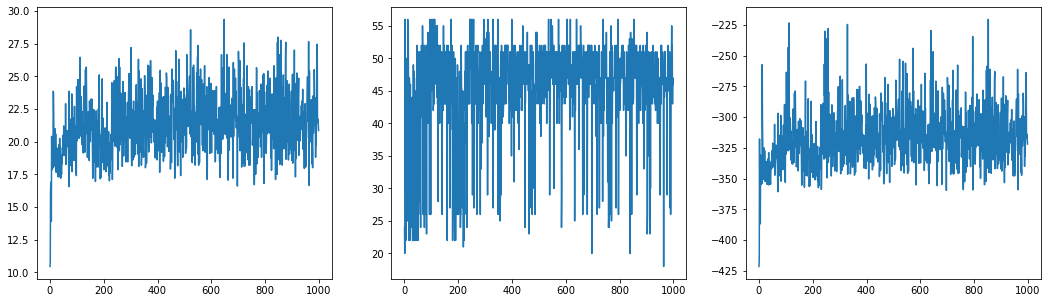

Best Fitness Score Gen 999: 46
Total Wins Gen 999: 25


In [24]:

pop, c1 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.05, 
                            crossoverRate=1, 
                            n_games=1)

Best Fitness Score Gen 0: 20
Total Wins Gen 0: 0


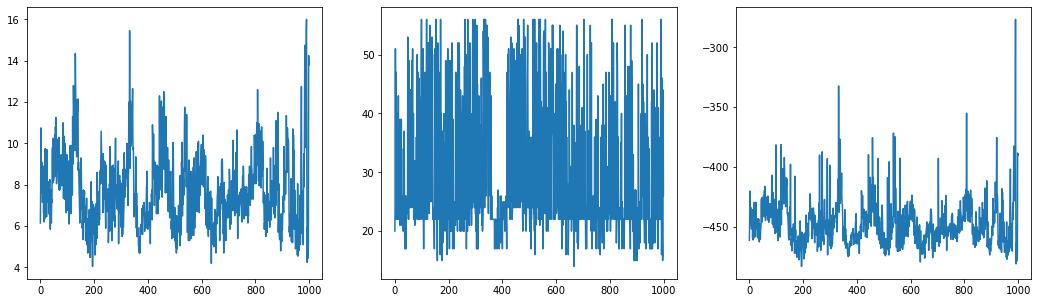

Best Fitness Score Gen 999: 26
Total Wins Gen 999: 22


In [25]:

pop, best_ind_c09 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.05, 
                            crossoverRate=0.9, 
                            n_games=1)

Best Fitness Score Gen 0: 22
Total Wins Gen 0: 0


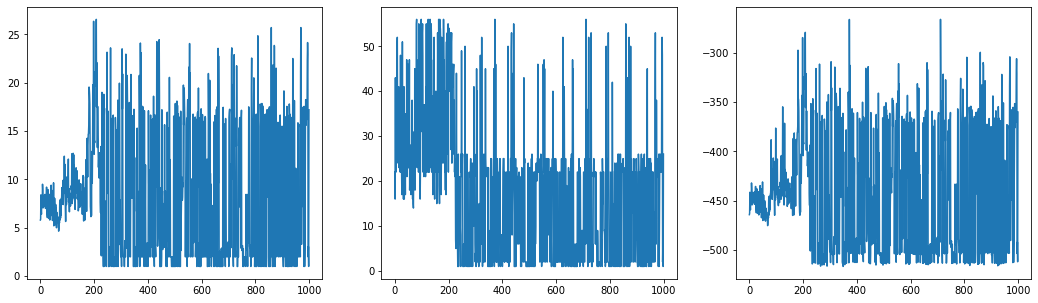

Best Fitness Score Gen 999: 26
Total Wins Gen 999: 9


In [26]:

pop, best_ind_c08 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.05, 
                            crossoverRate=0.8, 
                            n_games=1)

Como pudemos ver com a redução da crossover rate para 1 ele foi capaz de manter resultados positivos mais constantes

Agora vamos para nosso próximo parâmetro, aqui vamos variar a taxa de mutação, inciando com o minimo de 0.05

Best Fitness Score Gen 0: 42
Total Wins Gen 0: 0


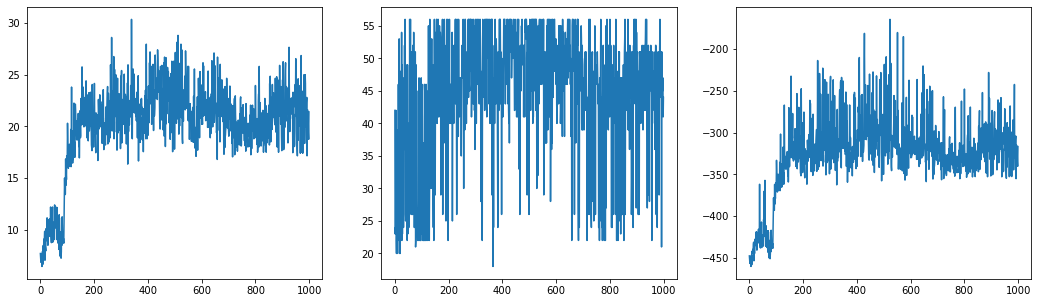

Best Fitness Score Gen 999: 44
Total Wins Gen 999: 115


In [27]:

pop, best_ind_m5 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.05, 
                            crossoverRate=1, 
                            n_games=1)

Best Fitness Score Gen 0: 22
Total Wins Gen 0: 0


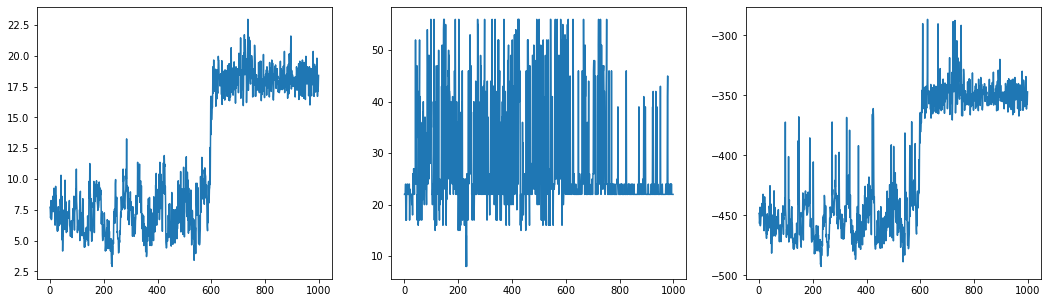

Best Fitness Score Gen 999: 22
Total Wins Gen 999: 28


In [28]:

pop, best_ind_m10 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.1, 
                            crossoverRate=1, 
                            n_games=1)

Best Fitness Score Gen 0: 21
Total Wins Gen 0: 0


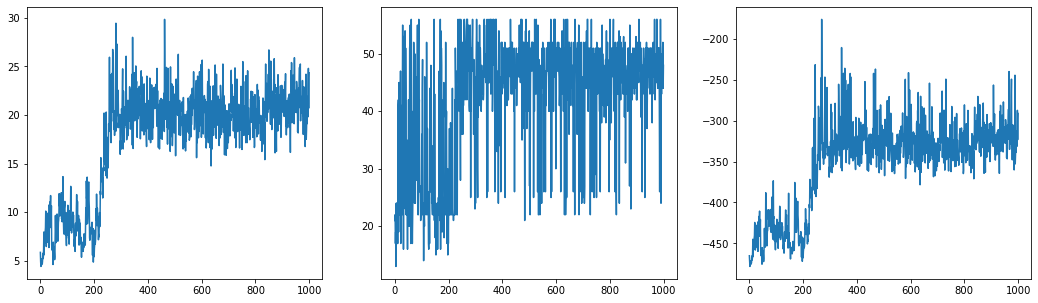

Best Fitness Score Gen 999: 48
Total Wins Gen 999: 49


In [29]:

pop, best_ind_m15 = train('smallClassic',
                            maxGen=1000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.15, 
                            crossoverRate=1, 
                            n_games=1)

Ainda que coma menor taxa de mutabilidade tenha trazido mais vitórias, as curvas de valores médio de aptidão mostram uma estabilidade mais elevate para a taxa de mutabilidade de 0.15, sendo essa a escolhida para prosseguir com o treinamento em amis gerações a ser feito na frente

Best Fitness Score Gen 0: 48
Total Wins Gen 0: 0
Best Fitness Score Gen 1000: 22
Total Wins Gen 1000: 7
Best Fitness Score Gen 2000: 22
Total Wins Gen 2000: 11
Best Fitness Score Gen 3000: 52
Total Wins Gen 3000: 39
Best Fitness Score Gen 4000: 56
Total Wins Gen 4000: 68
Best Fitness Score Gen 5000: 22
Total Wins Gen 5000: 71
Best Fitness Score Gen 6000: 22
Total Wins Gen 6000: 76
Best Fitness Score Gen 7000: 22
Total Wins Gen 7000: 76
Best Fitness Score Gen 8000: 47
Total Wins Gen 8000: 99
Best Fitness Score Gen 9000: 48
Total Wins Gen 9000: 147
Best Fitness Score Gen 10000: 22
Total Wins Gen 10000: 165
Best Fitness Score Gen 11000: 22
Total Wins Gen 11000: 165
Best Fitness Score Gen 12000: 22
Total Wins Gen 12000: 165
Best Fitness Score Gen 13000: 22
Total Wins Gen 13000: 165
Best Fitness Score Gen 14000: 48
Total Wins Gen 14000: 201
Best Fitness Score Gen 15000: 47
Total Wins Gen 15000: 239
Best Fitness Score Gen 16000: 45
Total Wins Gen 16000: 279
Best Fitness Score Gen 17000: 43
T

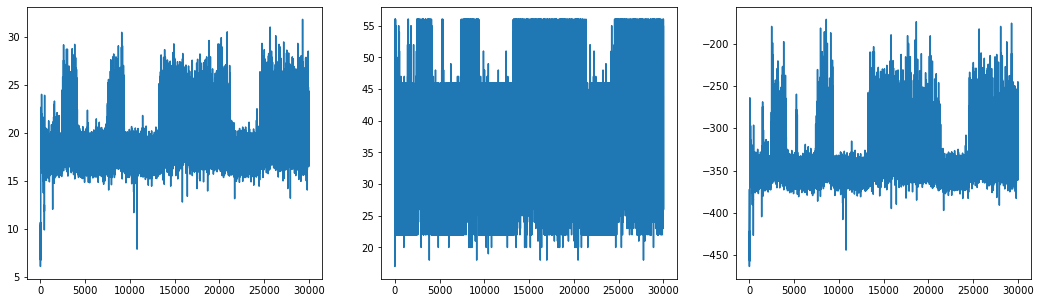

Best Fitness Score Gen 29999: 26
Total Wins Gen 29999: 706


In [31]:
pop, best_ind_small = train('smallClassic',
                            maxGen=30000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.15, 
                            crossoverRate=1, 
                            n_games=1)

In [64]:
best_agent_small = SingleLookAgent(best_ind_small)
best_agent_small.serialize("../../notebooks/results/small/geneticSmall.json")

### Treinamento -  Medium Classic <a name="title"/>

Best Fitness Score Gen 0: 91
Total Wins Gen 0: 0
Best Fitness Score Gen 1000: 98
Total Wins Gen 1000: 108
Indice bom de vitórias


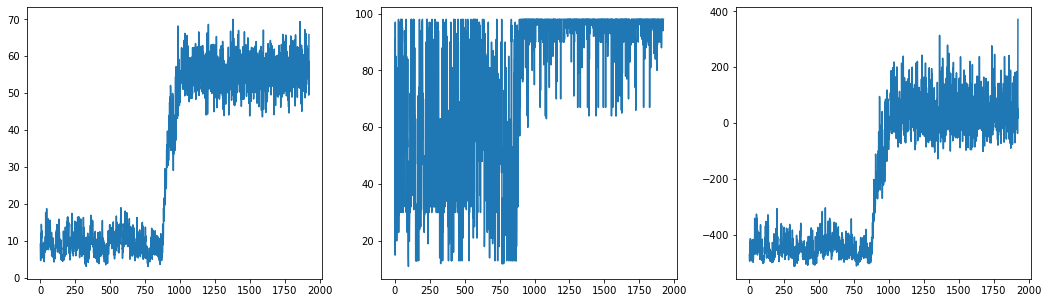

Best Fitness Score Gen 1923: 98
Total Wins Gen 1923: 801


In [32]:
pop, best_ind_medium = train('mediumClassic',
                            maxGen=30000, 
                            populationSize=20, 
                            selectionSize=3, 
                            newGenSize=17,
                            mutationRate=0.15, 
                            crossoverRate=1, 
                            n_games=1)

In [66]:
best_agent_medium = SingleLookAgent(best_ind_medium)
best_agent_medium.serialize("../../notebooks/results/medium/geneticMedium.json")

### Treinamento -  Original Classic <a name="title11"/>

Best Fitness Score Gen 0: 22
Total Wins Gen 0: 0
Best Fitness Score Gen 1000: 90
Total Wins Gen 1000: 1
Best Fitness Score Gen 2000: 63
Total Wins Gen 2000: 4


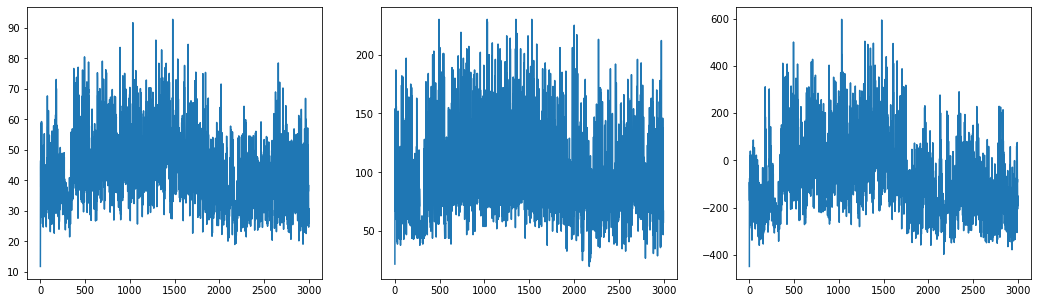

Best Fitness Score Gen 2999: 67
Total Wins Gen 2999: 4


In [89]:
pop, best_ind_original = train('originalClassic',
                            maxGen=3000, 
                            populationSize=10, 
                            selectionSize=3, 
                            newGenSize=7,
                            mutationRate=0.15, 
                            crossoverRate=1, 
                            n_games=1)

In [90]:
best_agent_original = SingleLookAgent(best_ind_original)
best_agent_original.serialize("../../notebooks/results/original/geneticOriginal.json")

# Parte II: Reinforcement Learning <a name="title13"/>

Essa parte do projeto tentará resolver o problema do Pacman utilizando o paradigma de Reinforcement Learning por meio do algoritmo de Qlearning

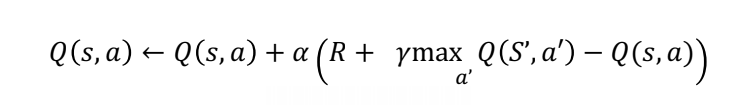  
<b>Imagem 1:</b> Equação Qlearning

O algoritmo Qlearning aprende atualizando a função ação-valor Q por meio dessa equação acima, em que ele atualiza o valor de um estado para a ação que escolhemos comparando com o valor de uma ação alternativa para o próximo estado. Detalharemos como isso está sendo feito a seguir.

In [20]:
%cd ../search/search
#! python pacman.py --layout originalClassic

[WinError 2] O sistema não pode encontrar o arquivo especificado: '../search/search'
C:\Users\Acer\projects_MachineLearning\project3_ra214129_ra216179\search\search


In [21]:
from pacman import runGames, readCommand
from game import Agent, Directions
from util import manhattanDistance
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [22]:
random.seed(7)

In [23]:
def getState(state):
    currentState = (state.getPacmanPosition(),Qlearn.getNearestFoodDis(state),state.getNumFood() + len(state.getCapsules()),Qlearn.nearestGhostPos(state))
    return currentState

In [24]:
def plotGraph(x,y,title,xlabel,ylabel,ax):
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

In [25]:
def plotGraphStandard(x,y,title,xlabel,ylabel,ax):
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

## Modelo <a name="title14"/>

Para a interface com o sistema do Pacman, nós criamos classes que herdam da classe Agent. Nós passamos as instâncias da classe como parâmetro para cada execução do jogo. O aprendizado é feito a cada chamada de getAction, em que o algoritmo escolhe uma ação e aprende a partir do resultado dela, chamando o método generatePacmanSuccessor.

Dentro de getAction(), o agente registra o estado atual e o seguinte, então ele escolhe uma ação com base no que já foi aprendido, ele também pega o reforço e, então, chama a função learn, que utiliza os estados e o reforço para aprender.

Para definir o estado utilizamos as seguintes informações: Posição do Pacman, distância para a comida mais próxima, quantidade de comidas e cápsulas, e a distância para o fantasma mais próximo. As distâncias utilizadas são distâncias manhattan, que são utilizadas pela biblioteca do Pacman e a função que calcula está disponível no script util.py. Para calcular a quantidade de comida, é chamada a função de game.state que retorna quantas comidas ainda faltam e calculando o tamanho da lista retornada pela função que pega a lista de cápsulas. Esse estado foi escolhido pensando em recompensar o pacman por tomar ações que facilitem sua vitória, como comer as comidas e se afastar dos fantasmas, e punir ações que o façam perder, como ir pra cima dos fantasmas, e também para evitar ficar muito tempo parado.

Para a função recompensa a princípio tentou-se utilizar como recompensa a pontuação gargsVSa cada ação, no entanto essa abordagem não apresentou bons resultados nos treinamentos iniciais, então optou-se por outra abordagem. A recompensa então é calculada utilizando a pontuação ganha, a distância que o pacman se aproximou ou afastou do fantasma mais próximo, a distância que ele se aproxima ou afastou da comida/cápsula mais próxima e quantas comidas ele comeu a cada ação. Isso é calculado subtraindo os dados do estado atual com o seguinte e a pontuação do próximo estado com a do estado atual. Esses valores são ponderados por constantes que foram escolhidas por meio de treinamento de forma a maximizar a quantidade de vitórias e também a pontuação a cada episódio. As contantes podem ser diferentes caso o valor do fator seja positivo ou negativo. A função reforço então fica:  
$$R(S_i,S_{i+1}) = c_1*ghostAproximation + c_2*foodAproximation + c_3*eatenFood + c_4*scoreGained$$

Vale ressaltar que o ambiente do Pacman já é discreto, portanto, a discretização não foi necessária para executar o Qlearning.

A cada iteração a ação é escolhida usando uma política é e-greedy, isso significa que com probabilidade <b>e</b> é escolhida uma ação aleatória, e com probabilidade <b>1 - e</b> é feita uma escolha gulosa da próxima ação, ou seja, a ação com maior valor de Q(s,a). O hiperparâmetro <b>e</b> é atualizado a cada episódio com a função: $$\frac{1}{k}$$ com k sendo o número do episódio. Para a atualização da tabela Q a ação escolhida para o estado seguinte é sempre escolhida de forma gulosa. Se uma, ou mais ações, tiverem o mesmo valor de Q(s,a), uma delas é escolhida aleatoriamente, em ambos os casos.

In [26]:
class Qlearn(Agent):
    def __init__(self, alpha,gamma,epsilon = 1,Qtable = {}):
        self.Qtable = Qtable
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.score = 0
        self.action = None
        self.currentState = None
        self.actions = []
        self.currentActions = 0
        self.rewards = []
        self.reward = 0
        self.scores = []
    
    def getQvalue(self,state,action):
        pair = str((state,action))
        return self.Qtable.get(pair,0.0)
    
    def getAction(self, state):
        actions = state.getLegalPacmanActions()
        self.score = state.getScore()
        currentState = getState(state)
        action = self.getBestAction(currentState,actions)
        state2 = state.generatePacmanSuccessor(action)
        nextState = getState(state2)
        if state2.isLose():
            reinforcement = -20000
        elif state2.isWin():
            reinforcement = 20000
        else:
            reinforcement = self.getReward(currentState,nextState,state2.getScore())
        self.learn(currentState,nextState,action,actions,reinforcement)
        self.action = action
        self.currentState = currentState
        self.currentActions += 1
        self.reward += reinforcement
        return action
        
        
    def nearestGhostPos(state):
        ghostList = state.getGhostPositions()
        nearestDistance = Qlearn.getNearGhost(state.getPacmanPosition(),ghostList)
        return nearestDistance

    def getNearGhost(pacman,ghosts):
        minDis = float("inf")
        minPos = -1
        for i in range(len(ghosts)):
            distance = manhattanDistance(pacman,ghosts[i])
            if distance < minDis:
                minDis = distance
                minPos = i
        if minPos > -1:
            return ghosts[minPos]
        else:
            return (-1,-1)

    def getNearestFoodDis(state):
        posList = Qlearn.getFoodPos(state.getFood())
        posList = posList + state.getCapsules()
        minDis = minDis = float("inf")
        #minPos = (-1,-1)
        pacPos = state.getPacmanPosition()
        for i in posList:
            distance = manhattanDistance(pacPos,i)
            if distance < minDis:
                minDis = distance
                #minPos = i
        return minDis


    def getFoodPos(grid):
        posList = []
        gridList = grid.asList()
        for i in range(len(gridList)):
            for j in range(len(gridList[i])):
                if gridList[i][j]:
                    posList.append((i,j))
        return posList

    def getBestAction(self,currentState,actions):
        if random.random() < self.epsilon:
            return random.choice(actions)
        maxValue = float("-inf")
        maxAction = []
        for i in actions:
            value = self.getQvalue(currentState,i)
            if value > maxValue:
                maxValue = value
                maxAction = [i]
            if value == maxValue:
                maxAction.append(i)
        #print(maxValue)
        #print(maxAction)
        return random.choice(maxAction)

    def learn(self,currentState,nextState,action,actions,reinforcement):
        nextActions = [self.getQvalue(nextState,a) for a in actions]
        if len(nextActions) > 0:
            newQ = max(nextActions)
        else:
            newQ = 0
        currentQ = self.getQvalue(currentState,action)
        self.Qtable[str((currentState,action))] = currentQ + self.alpha * (reinforcement + (self.gamma*newQ) - currentQ)

    def setEpsilon(self,epsilon):
        self.epsilon = epsilon

    def serialize(self,path):
        try:
            f = open(path,"w")
            json.dump(self.Qtable,f)
            f.close()
        except:
            raise Exception("You've got an error")

    def desserialize(self,path):
        try:
            f = open(path,"r")
            self.Qtable = json.load(f)
            f.close()
        except:
            raise Exception("You've got an error")
    
    def getReward(self,state1,state2,score):
        pacGhostDistance1 = manhattanDistance(state1[0],state1[3])
        pacGhostDistance2 = manhattanDistance(state2[0],state2[3])
        #fDis1 = manhattanDistance(state1[0],state1[1])
        #fDis2 = manhattanDistance(state2[0],state2[1])
        eatenFood = state2[2] - state1[2]
        ghostDistance = pacGhostDistance2 - pacGhostDistance1
        foodDistance = state2[1] - state1[1]
        scoreDifference = score - self.score
        if ghostDistance > 0:
            ghostReward = ghostDistance*200
        else:
            ghostReward = 200*ghostDistance
        if foodDistance < 0:
            foodReward = -500 * foodDistance
        else:
            foodReward = 0
        if eatenFood > 0:
            eatReward = 500*eatenFood
        else:
            eatReward = 0
        if scoreDifference > 0:
            scoreReward = 3*scoreDifference
        else:
            scoreReward = 5*scoreDifference
        return ghostReward + foodReward + eatReward + scoreReward
    
    def win(self,terminal):
        self.saveResult(terminal.state.getScore())
        self.learn(self.currentState,getState(terminal.state),self.action,terminal.state.getLegalPacmanActions(),20000)
    
    def lose(self,terminal):
        self.saveResult(terminal.state.getScore())
        self.learn(self.currentState,getState(terminal.state),self.action,terminal.state.getLegalPacmanActions(),-20000)
    
    def saveResult(self, score):
        self.actions.append(self.currentActions)
        self.scores.append(score)
        self.rewards.append(self.reward)
        self.currentActions = 0
        self.reward = 0
        self.score = 0
    
    def printResult(self,k):
        fig, ax = plt.subplots(1,3)
        episodes = [i for i in range(1,k+1)]
        plotGraph(episodes,self.actions,"Actions per Episode","Episodes","Actions",ax[0])
        plotGraph(episodes,self.scores,"Score per Episode","Episodes","Score",ax[1])
        plotGraph(episodes,self.rewards,"Reward per Episode","Episodes","Reward",ax[2])   
        fig.set_size_inches(25,5)

Para salvar os estados de nossos treinos e poder reaproveitá-los depois, nós serializamos os resultados dos nossos treinamentos salvando a Q table produzida em um arquivo json, que se encontra em [resultados](results). 

Pelo modelo escolhido, os hiperparâmetros são: Constante da distância do fantasma (GhostReward), constante da distância da comida (FoodReward), constante de comidas ingeridas (EatReward) e constante de pontuação (ScoreReward) para a função recompensa; e as constantes taxa de aprendizado (Alpha) e taxa de desconto temporal (Gamma) para o algoritmo no geral, além do epsilon, que foi explicado anteriormente.  A tabela abaixo exibe os valores dessas constantes para a nossa melhor tentativa no layout "smallClassical".

Hiperparâmetro | Positivo | Negativo
-------------- | ---------| -----------
GhostReward    |  200     |  200
FoodReward     |  0       | -500
EatReward      |  500     |  0
ScoreReward    |  3       |  5
Alpha          |  0.85    |  -
Gamma          |  0.5     |  -  

<p style="text-align: center;"><b>Tabela 1:</b> Hiperparâmetros usados no nosso melhor resultado</p>  

Abaixo alguns dados sobre essa execução:  
* Número de episódios: 40000
* Primeira vitória: 6961  
* Total de vitórias: 125  
* Pontuação média: -336.336175

In [27]:
def showResults(agente,k):
    for i in range(0,k-1,1000):
        try:    
            print("Episode "+str(i+1)+": Number of actions = "+str(agente.actions[i])+"; Total score = "+str(agente.scores[i])+"; Total Reward = "+str(agente.rewards[i]))
        except(IndexError):
            print("Index out of range")
            break

In [28]:
args = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","smallClassic"])

## Treinamento <a name="title15"/>

Para o treinamento, o mecanismo de parada escolhido foi o número de 40000 episódios, que foi escolhido por ser grande o suficiente pra ter apresentado resultados consideráveis enquanto testávamos o modelo, além de não termos conseguido executar por mais episódios por limitações de hardware.

In [9]:
a = []

In [10]:
agente = Qlearn(0.85,0.5,epsilon = 1)
args["pacman"] = agente

In [11]:
victorys = []
k = 40000
summ = 0
for i in range(k):
    agente.setEpsilon(1/(i+1))
    a.append(runGames(**args))
    if a[i][0].state.isLose():
        agente.lose(a[i][0])
    elif a[i][0].state.isWin():
        agente.win(a[i][0])
        victorys.append(a[i])
        print(i)
    summ += a[i][0].state.getScore()

Pacman emerges victorious! Score: 664
6961
Pacman emerges victorious! Score: 587
7234
Pacman emerges victorious! Score: 881
7753
Pacman emerges victorious! Score: 710
8192
Pacman emerges victorious! Score: 895
8986
Pacman emerges victorious! Score: 599
10371
Pacman emerges victorious! Score: 970
10618
Pacman emerges victorious! Score: 910
10782
Pacman emerges victorious! Score: 831
11155
Pacman emerges victorious! Score: 650
11501
Pacman emerges victorious! Score: 483
12050
Pacman emerges victorious! Score: 646
12863
Pacman emerges victorious! Score: 774
13171
Pacman emerges victorious! Score: 734
13342
Pacman emerges victorious! Score: 653
14939
Pacman emerges victorious! Score: 516
15339
Pacman emerges victorious! Score: 774
15409
Pacman emerges victorious! Score: 815
15752
Pacman emerges victorious! Score: 651
16149
Pacman emerges victorious! Score: 537
16269
Pacman emerges victorious! Score: 892
16418
Pacman emerges victorious! Score: 699
16636
Pacman emerges victorious! Score: 592

In [12]:
showResults(agente,k)

Episode 1: Number of actions = 14; Total score = -454.0; Total Reward = -19073.0
Episode 1001: Number of actions = 33; Total score = -383.0; Total Reward = -15812.0
Episode 2001: Number of actions = 211; Total score = -291.0; Total Reward = 35689.0
Episode 3001: Number of actions = 86; Total score = -226.0; Total Reward = 15322.0
Episode 4001: Number of actions = 327; Total score = -537.0; Total Reward = 30498.0
Episode 5001: Number of actions = 58; Total score = -318.0; Total Reward = 10278.0
Episode 6001: Number of actions = 68; Total score = -328.0; Total Reward = 10428.0
Episode 7001: Number of actions = 144; Total score = -314.0; Total Reward = 4741.0
Episode 8001: Number of actions = 157; Total score = -407.0; Total Reward = 21315.0
Episode 9001: Number of actions = 168; Total score = -288.0; Total Reward = 35176.0
Episode 10001: Number of actions = 327; Total score = -407.0; Total Reward = 47109.0
Episode 11001: Number of actions = 206; Total score = -486.0; Total Reward = 23874

In [13]:
agente.serialize("../../notebooks/results/small/a085-g03-d110721.json")

In [14]:
print(len(victorys))
print(summ/k)

125
-336.336175


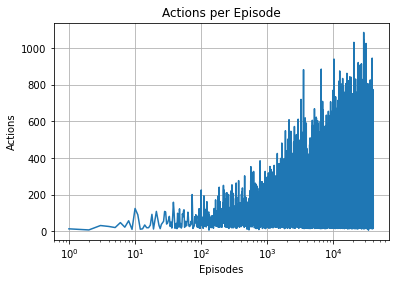

In [24]:
agente.printResult(k)

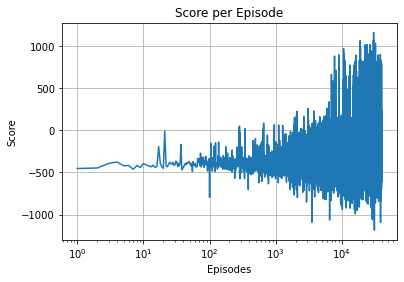

In [25]:
#plotGraph(episodes,agente.scores,"Score per Episode","Episodes","Score")

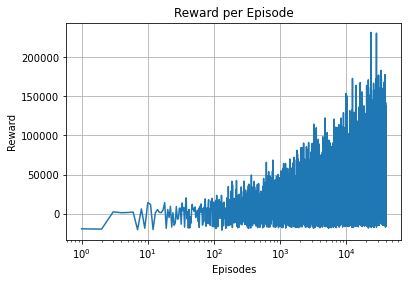

In [26]:
#plotGraph(episodes,agente.rewards,"Reward per Episode","Episodes","Reward")  

A execução desse melhor modelo que obtivemos mostrou algumas coisas interessantes, mesmo o percentual de vitórias ainda sendo bastante baixo, 125 em 40000 episódios (0,31% aproximadamente) e a média de pontos também ser bastante baixa (-336,34 aproximadamente), este não é um mau resultado. Uma boa parte desses valores ruins se dá pela quantidade alta de episódios antes do modelo começar a aprender, a primeira vitória foi no episódio 6961. Além disso, como podemos observar nos gráficos, há coisas que apenas o número de vitórias e média de pontos não conseguem descrever. Os três gráficos mostram uma melhora considerável do modelo ao longo dos episódios, tanto em número de ações, quanto em pontuação, quanto em reforço. Ao longo dos episódios, as três métricas melhoraram, especialmente após algumas milhares de execuções, e pela escala logarítima, podemos notar que a melhora do modelo se dá em escala logarítimica, uma vez que ele apresenta um crescimento razoavelmente linear nessa escala nos gráficos de ações e reforço, o que pode explicar a quantidade grande de episódios necessária pra obter um bom resultado

In [10]:
argsM = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","mediumClassic"])

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'mediumClassic']


In [11]:
aM = []

In [12]:
agenteM = Qlearn(0.85,0.5,epsilon = 1)
argsM["pacman"] = agenteM

In [13]:
victorysM = []
kM = 40000
summM = 0
for i in range(kM):
    agenteM.setEpsilon(1/(i+1))
    aM.append(runGames(**argsM))
    if aM[i][0].state.isLose():
        agenteM.lose(aM[i][0])
    elif aM[i][0].state.isWin():
        agenteM.win(aM[i][0])
        victorysM.append(aM[i])
        print(i)
    summM += aM[i][0].state.getScore()

In [14]:
agenteM.serialize("../../notebooks/results/medium/a085-g05-d110721-2.json")

In [15]:
showResults(agenteM,kM)

Episode 1: Number of actions = 24; Total score = -474.0; Total Reward = 2340.0
Episode 1001: Number of actions = 200; Total score = -260.0; Total Reward = 2375.0
Episode 2001: Number of actions = 141; Total score = -381.0; Total Reward = 24427.0
Episode 3001: Number of actions = 223; Total score = -443.0; Total Reward = 38281.0
Episode 4001: Number of actions = 171; Total score = 109.0; Total Reward = 12468.0
Episode 5001: Number of actions = 166; Total score = -456.0; Total Reward = -11653.0
Episode 6001: Number of actions = 314; Total score = -424.0; Total Reward = 30978.0
Episode 7001: Number of actions = 54; Total score = -454.0; Total Reward = 4550.0
Episode 8001: Number of actions = 194; Total score = -34.0; Total Reward = 22902.0
Episode 9001: Number of actions = 257; Total score = -247.0; Total Reward = 17314.0
Episode 10001: Number of actions = 84; Total score = -424.0; Total Reward = 10392.0
Episode 11001: Number of actions = 204; Total score = -324.0; Total Reward = 9101.0
E

In [16]:
print(len(victorysM))
print(summM/kM)

0
-387.8459


In [ ]:
agenteM.printResult(kM)

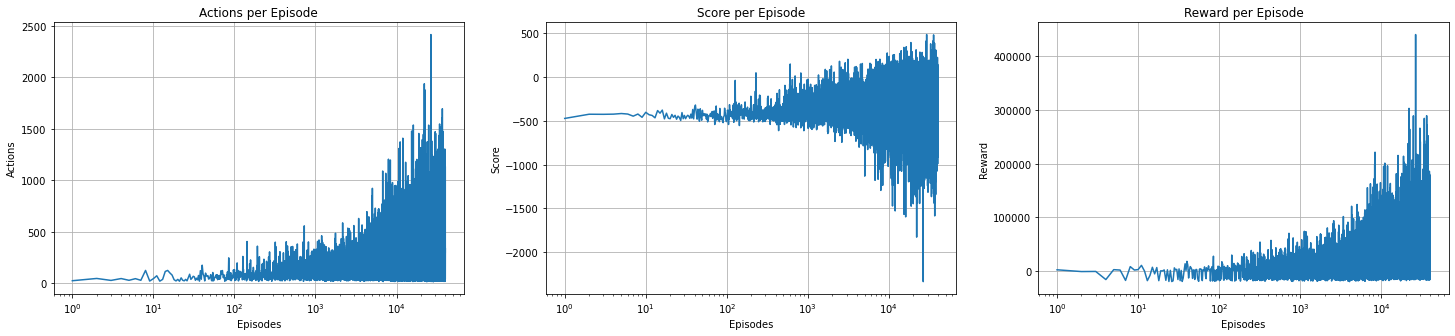

In [23]:
#fig, ax = plt.subplots(1,3)
#episodes = [i for i in range(1,kM+1)]
#plotGraph(episodes,agenteM.actions,"Actions per Episode","Episodes","Actions",ax[0])
#plotGraph(episodes,agenteM.scores,"Score per Episode","Episodes","Score",ax[1])
#plotGraph(episodes,agenteM.rewards,"Reward per Episode","Episodes","Reward",ax[2])   
#fig.set_size_inches(25,5)

Rodando o mesmo modelo para o layout mediumClassic, obtivemos um resultado aparentemente muito pior, sem nenhuma vitória e com a mesma média de pontos. Porém os gráficos mostram uma evolução muito parecida com o layout anterior em todas as métricas, mostrando que talvez ele começasse a ganhar se deixássemos mais tempo treinando, o que não foi possível, tentamos deixar treinando por 80000 épocas, mas todas as tentativas resultaram em travamento completo da máquina, sendo necessário um desligamento forçado, o que indica estouro do limite da memória principal. A pontuação nesse modelo foi, no geral, mais negativa que para o layout anterior, porém possui uma boa quantidade de episódios com pontuação positiva, a recompensa recebida por episódio foi maior, o que de se esperar com um tabuleiro maior, o mesmo se aplica às ações por epísódio, foram em número maior, o que também deve ser consequência do tabuleiro maior. Sobre a execução específica executada para a confecção desse relatório, é observada uma região com uma recompensa e número de ações muito superior à de qualquer outra região do gráfico, o que pode indicar que nessa área o pacman quase conseguiu uma vitória, ou uma série de vitórias, o que talvez fosse mais frequente se permitíssemos que ele treinasse por mais tempo.

In [8]:
argsO = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","originalClassic"])

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'originalClassic']


In [9]:
aO = []

In [10]:
agenteO = Qlearn(0.85,0.5,epsilon = 1)
argsO["pacman"] = agenteO

In [11]:
victorysO = []
kO = 40000
summO = 0
for i in range(kO):
    agenteO.setEpsilon(1/(i+1))
    aO.append(runGames(**argsO))
    if aO[i][0].state.isLose():
        agenteO.lose(aO[i][0])
    elif aO[i][0].state.isWin():
        agenteO.win(aO[i][0])
        victorysO.append(aO[i])
        print(i)
    summO += aO[i][0].state.getScore()

In [12]:
agenteO.serialize("../../notebooks/results/original/a085-g05-d120721.json")

In [13]:
showResults(agenteO,kO)

Episode 1: Number of actions = 31; Total score = -451.0; Total Reward = 901.0
Episode 1001: Number of actions = 51; Total score = -411.0; Total Reward = 3993.0
Episode 2001: Number of actions = 39; Total score = -469.0; Total Reward = 629.0
Episode 3001: Number of actions = 82; Total score = -412.0; Total Reward = 6134.0
Episode 4001: Number of actions = 305; Total score = -325.0; Total Reward = 2716.0
Episode 5001: Number of actions = 664; Total score = -174.0; Total Reward = 99415.0
Episode 6001: Number of actions = 126; Total score = -446.0; Total Reward = 6546.0
Episode 7001: Number of actions = 159; Total score = -539.0; Total Reward = 2989.0
Episode 8001: Number of actions = 309; Total score = -479.0; Total Reward = 15811.0
Episode 9001: Number of actions = 390; Total score = -670.0; Total Reward = 4654.0
Episode 10001: Number of actions = 116; Total score = -476.0; Total Reward = 3568.0
Episode 11001: Number of actions = 83; Total score = -463.0; Total Reward = 2769.0
Episode 12

In [14]:
print(len(victorysO))
print(summO/kO)

0
-483.3158


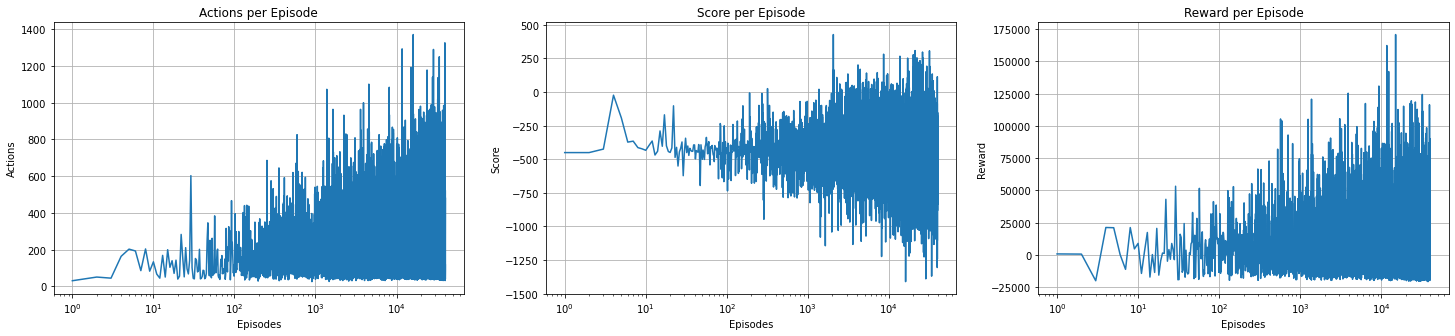

In [17]:
agenteO.printResult(kO)

Por fim, para o Layout original observamos que também não obteve vitórias e a média de pontos também é muito baixa. Esse comportamento possivelmente se deve a necessitar de mais treinamento, por ser o maior cenário, porém, o mesmo problema do anterior evitou que pudéssemos treinar por mais episódios. Aqui observa-se que a recompensa por episódio e a quantidade de ações se manteve mais baixa que no cenário médio, mesmo tendo a possbilidade de ser maior por conta do tamanho do cenário permitir maior número de ações e consequentemente de recompensa. Ou seja, apesar de apresentar o mesmo padrão de crescimento dos outros cenários, ele se comportou pior que o anterior, o que pode indicar um potencial overfitting do modelo para os menores cenários, o que também pode explicar o menor layout ter apresentado várias vitórias e os outros não. Os resultados apresentados possivelmente são uma combinação dos dois fatores, necessidade de mais treinamento e overfitting, porém essa hipótese não pode ser testada por conta das limitações de hardware.

## Execução <a name="title16"/>

Para a execução criamos uma segunda classe chamada smartPacman que carrega os jsons produzidos pelo Qlearning e o usa como Qtable, utilizando dessa vez uma escolha completamente gulosa, para cada estado ele escolhe a ação com o maior valor de Q(s,a), em caso de empate ele escolhe uma ação aleatoriamente.

In [29]:
class smartPacman(Agent):
    def __init__(self, path):
        self.desserialize(path)
        self.score = 0
        self.action = 0
        self.scores = []
        self.actions = []
        self.win = 0
    
    def getQvalue(self,state,action):
        pair = str((state,action))
        return self.Qtable.get(pair,0.0)
    
    def getAction(self, state):
        actions = state.getLegalPacmanActions()
        currentState = getState(state)
        action = self.getBestAction(currentState,actions)
        return action
    
    def getBestAction(self,currentState,actions):
        maxValue = float("-inf")
        maxAction = []
        for i in actions:
            value = self.getQvalue(currentState,i)
            if value > maxValue:
                maxValue = value
                maxAction = [i]
            if value == maxValue:
                maxAction.append(i)
        #print(maxValue)
        #print(maxAction)
        self.action += 1
        return random.choice(maxAction)
    
    def desserialize(self,path):
        try:
            f = open(path,"r")
            self.Qtable = json.load(f)
            f.close()
        except:
            raise Exception("You've got an error")
    def finish(self,state,episode):
        if state.isWin():
            self.win +=1
        self.score = state.getScore()
        print("Episode: "+str(episode)+"; Score = "+str(self.score)+"; Actions = "+str(self.action))
        self.scores.append(self.score)
        self.actions.append(self.action)
        self.action = 0
    
    def printResult(self,k):
        fig, ax = plt.subplots(1,2)
        episodes = [i for i in range(1,k+1)]
        plotGraphStandard(episodes,self.actions,"Actions per Episode","Episodes","Actions",ax[0])
        plotGraphStandard(episodes,self.scores,"Score per Episode","Episodes","Score",ax[1])
        fig.set_size_inches(20,5)
    
    def winRate(self,k):
        summ = 0
        for i in self.scores:
            summ += i
        scoreAverage = summ/k
        winRate = (self.win/k) * 100
        print("Score average = "+ str(scoreAverage))
        print("Rate of wins = "+ str(winRate)+"%")

Aqui é possível escolher um resultado para observar como ele se comporta graficamente.

### Avaliação - Small Classic <a name="title17"/>

In [14]:
agenteEspertoS = smartPacman("../../notebooks/results/small/a085-g03-d110721.json")
argsVS = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","smallClassic"])
argsVS["pacman"] = agenteEspertoS

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'smallClassic']


In [15]:
bS = []
kP = 10
for i in range(kP):
    bS.append(runGames(**argsVS))
    print(bS[i][0].state.isWin())
    print(bS[i][0].state.getScore())
    agenteEspertoS.finish(bS[i][0].state,i+1)

False
-176.0
Episode: 1; Score = -176.0; Actions = 236
False
-406.0
Episode: 2; Score = -406.0; Actions = 196
False
-371.0
Episode: 3; Score = -371.0; Actions = 81
False
-293.0
Episode: 4; Score = -293.0; Actions = 183
False
-358.0
Episode: 5; Score = -358.0; Actions = 78
False
-175.0
Episode: 6; Score = -175.0; Actions = 65
False
-120.0
Episode: 7; Score = -120.0; Actions = 330
False
-378.0
Episode: 8; Score = -378.0; Actions = 28
False
-456.0
Episode: 9; Score = -456.0; Actions = 166
False
-744.0
Episode: 10; Score = -744.0; Actions = 914


Score average = -347.7
Rate of wins = 0.0%


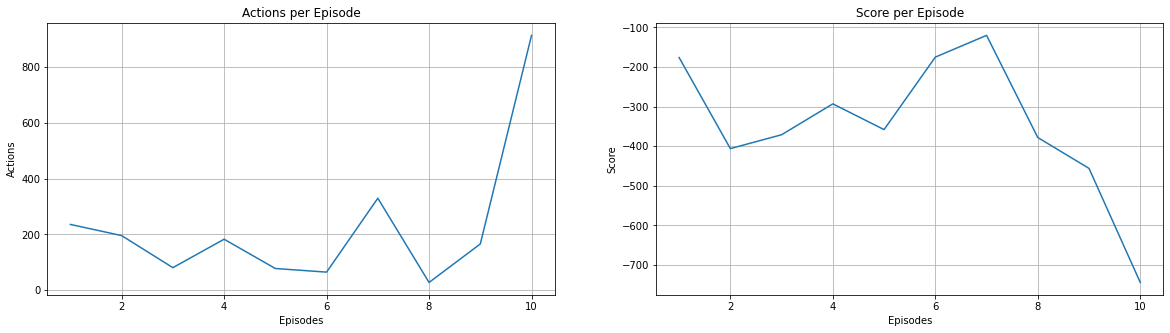

In [16]:
agenteEspertoS.printResult(kP)
agenteEspertoS.winRate(kP)

Para o layout pequeno observamos uma pequena variação na quantidade de ações ao longo das 10 execuções, com exceção das últimas que fizeram bem mais ações que a média. O mesmo comportamento é observado na pontuação, só que inverso, as últimas execuções tem pontuações muito mais negativas que as outras, que oscilam em torno de um valor. No geral, o desempenho é ruim, uma pontuação baixa e uma taxa de vitória de 0%, isso era esperado, uma vez que a taxa de vitória em treino foi de 0.31%, sendo que para 10 execuções, uma vitória já daria uma taxa de 10%, então o desempenho do Pacman nessas execuções foi dentro do observado anteriormente, com uma média de pontuação também próxima do que foi visto.

In [52]:
####################
# GENÉTICO
####################

test_agent_small = SingleLookAgent(create_random_chromossome())
test_agent_small.desserialize("../../notebooks/results/small/geneticSmall.json")

Score Média: -154.4
Max Score: 977.0
Wins: 1


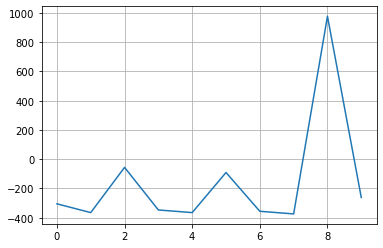

In [53]:

argsVS = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","smallClassic"])
argsVS["pacman"] = test_agent_small
score= []
wins = 0
kP = 10
for i in range(kP):
    game = runGames(**argsVS)
    score.append(game[0].state.getScore())
    if game[0].state.isWin():
        wins += 1
print(f"Score Média: {statistics.mean(score)}")
print(f"Max Score: {max(score)}")
print(f"Wins: {wins}")
plt.plot(score)
plt.grid(True)

Desem penho bem instável, tendo apenas 1 run verdadeiramente boas mas que atingiu a vitória, o restante ficou, inclusive, negativo

### Avaliação - Medium Classic <a name="title18"/>

In [18]:
agenteEspertoM = smartPacman("../../notebooks/results/medium/a085-g05-d110721-2.json")
argsVM = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","mediumClassic"])
argsVM["pacman"] = agenteEspertoM

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'mediumClassic']


In [19]:
bM = []
kM = 10
for i in range(kM):
    bM.append(runGames(**argsVM))
    print(bM[i][0].state.isWin())
    print(bM[i][0].state.getScore())
    agenteEspertoM.finish(bM[i][0].state,i+1)

False
-376.0
Episode: 1; Score = -376.0; Actions = 256
False
-374.0
Episode: 2; Score = -374.0; Actions = 114
False
-670.0
Episode: 3; Score = -670.0; Actions = 660
False
-293.0
Episode: 4; Score = -293.0; Actions = 233
False
-418.0
Episode: 5; Score = -418.0; Actions = 178
False
-457.0
Episode: 6; Score = -457.0; Actions = 27
False
-386.0
Episode: 7; Score = -386.0; Actions = 96
False
-404.0
Episode: 8; Score = -404.0; Actions = 204
False
-519.0
Episode: 9; Score = -519.0; Actions = 479
False
-512.0
Episode: 10; Score = -512.0; Actions = 242


Score average = -440.9
Rate of wins = 0.0%


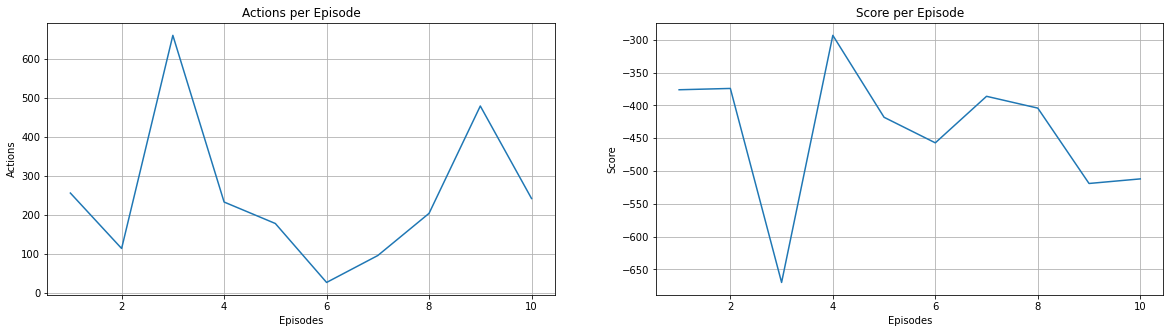

In [20]:
agenteEspertoM.printResult(kM)
agenteEspertoM.winRate(kM)

Nesse layout o resultado foi semelhante, nenhuma vitória e com número de ações e pontuação ainda menor que o anterior, o que também condiz com os resultados de treinamento, porém a média de pontuação foi menor que a observada no treinamento, o que pode ser consequência da quantidade baixa de execuções.

In [43]:
####################
# GENÉTICO
####################

test_agent_medium = SingleLookAgent(create_random_chromossome())
test_agent_medium.desserialize("../../notebooks/results/medium/geneticMedium.json")

Score Média: 658.0
Max Score: 1842.0
Wins: 3


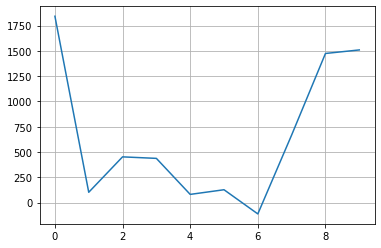

In [44]:

argsVS = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","mediumClassic"])
argsVS["pacman"] = test_agent_medium
score= []
wins = 0
kP = 10
for i in range(kP):
    game = runGames(**argsVS)
    score.append(game[0].state.getScore())
    if game[0].state.isWin():
        wins += 1
print(f"Score Média: {statistics.mean(score)}")
print(f"Max Score: {max(score)}")
print(f"Wins: {wins}")
plt.plot(score)
plt.grid(True)

Número de vitórias superior ao primeiro, mas aidna assim alcancçando scores bem altos em relação ao outro modelo e conseguindo três vitórias, além de um score relativamente bom

### Avaliação -Originial Classic <a name="title19"/>

In [22]:
agenteEspertoO = smartPacman("../../notebooks/results/original/a085-g05-d120721.json")
argsVO = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","originalClassic"])
argsVO["pacman"] = agenteEspertoO

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'originalClassic']


In [23]:
bO = []
kO = 10
for i in range(kO):
    bO.append(runGames(**argsVO))
    print(bO[i][0].state.isWin())
    print(bO[i][0].state.getScore())
    agenteEspertoO.finish(bO[i][0].state,i+1)

False
-585.0
Episode: 1; Score = -585.0; Actions = 105
False
-606.0
Episode: 2; Score = -606.0; Actions = 126
False
-517.0
Episode: 3; Score = -517.0; Actions = 47
False
-538.0
Episode: 4; Score = -538.0; Actions = 68
False
-533.0
Episode: 5; Score = -533.0; Actions = 63
False
-440.0
Episode: 6; Score = -440.0; Actions = 70
False
-621.0
Episode: 7; Score = -621.0; Actions = 161
False
-474.0
Episode: 8; Score = -474.0; Actions = 124
False
-644.0
Episode: 9; Score = -644.0; Actions = 264
False
-561.0
Episode: 10; Score = -561.0; Actions = 91


Score average = -551.9
Rate of wins = 0.0%


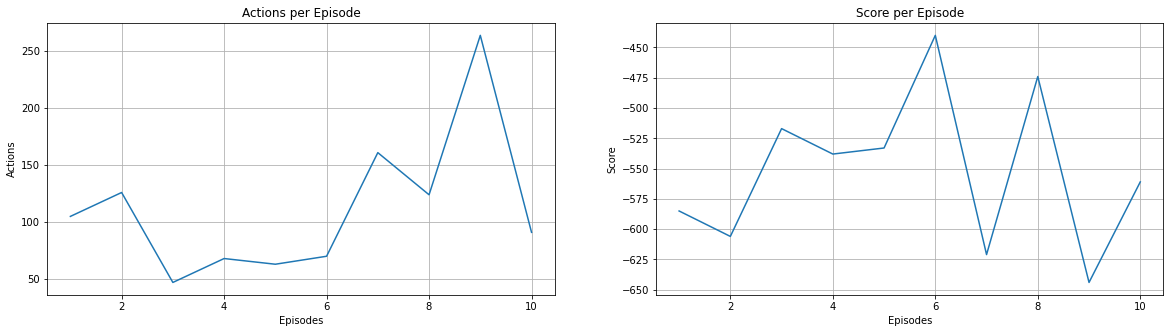

In [24]:
agenteEspertoO.printResult(kO)
agenteEspertoO.winRate(kO)

Esse foi o layout com pior desempenho, o que também parece plausível, sendo que este modelo também teve o pior desempenho nos treinos. Ele foi o que executou menos ações, ganhou menos pontos, também não teve nenhuma vitória e a média de pontos foi inferior à média dos treinamentos. Esse comportamento também sofreu do efeito de poucas execuções, e comprova que o modelo sofreu com uma quantidade menor de treinos e o possível overfitting.

In [54]:
####################
# GENÉTICO
####################

test_agent_original = SingleLookAgent(create_random_chromossome())
test_agent_original.desserialize("../../notebooks/results/medium/geneticMedium.json")

Score Média: 594.7
Max Score: 1038.0
Wins: 0


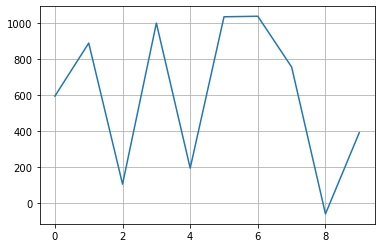

In [55]:
argsVS = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","originalClassic"])
argsVS["pacman"] = test_agent_original
score= []
wins = 0
kP = 10
for i in range(kP):
    game = runGames(**argsVS)
    score.append(game[0].state.getScore())
    if game[0].state.isWin():
        wins += 1
print(f"Score Média: {statistics.mean(score)}")
print(f"Max Score: {max(score)}")
print(f"Wins: {wins}")
plt.plot(score)
plt.grid(True)

Esse último labirinto não obteve nenhuma vitória, possivelmente por conta do baixo numeros de gerações que foi possívle deixa-lo treinando, mas ainda assim teve scores consideravelemtne bons apesar disso

### Comparação com agente aleatório <a name="title20"/>

In [41]:
class randomPacman(Agent):
    def __init__(self):
        self.score = 0
        self.action = 0
        self.scores = []
        self.actions = []
        self.win = 0
    
    def getAction(self, state):
        actions = state.getLegalPacmanActions()
        action = random.choice(actions)
        self.action += 1
        return action

    def finish(self,state,episode):
        if state.isWin():
            self.win +=1
        self.score = state.getScore()
        print("Episode: "+str(episode)+"; Score = "+str(self.score)+"; Actions = "+str(self.action))
        self.scores.append(self.score)
        self.actions.append(self.action)
        self.action = 0
    
    def printResult(self,k):
        fig, ax = plt.subplots(1,2)
        episodes = [i for i in range(1,k+1)]
        plotGraphStandard(episodes,self.actions,"Actions per Episode","Episodes","Actions",ax[0])
        plotGraphStandard(episodes,self.scores,"Score per Episode","Episodes","Score",ax[1])
        fig.set_size_inches(20,5)
    
    def winRate(self,k):
        summ = 0
        for i in self.scores:
            summ += i
        scoreAverage = summ/k
        winRate = (self.win/k) * 100
        print("Score average = "+ str(scoreAverage))
        print("Rate of wins = "+ str(winRate)+"%")

In [39]:
agenteAleatorioS = randomPacman()
argsRS = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","smallClassic"])
argsRS["pacman"] = agenteAleatorioS

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'smallClassic']


In [40]:
bRS = []
kRS = 10
for i in range(kRS):
    bRS.append(runGames(**argsRS))
    print(bRS[i][0].state.isWin())
    print(bRS[i][0].state.getScore())
    agenteAleatorioS.finish(bRS[i][0].state,i+1)

False
-443.0
Episode: 1; Score = -443.0; Actions = 53
False
-484.0
Episode: 2; Score = -484.0; Actions = 34
False
-469.0
Episode: 3; Score = -469.0; Actions = 9
False
-454.0
Episode: 4; Score = -454.0; Actions = 44
False
-392.0
Episode: 5; Score = -392.0; Actions = 62
False
-455.0
Episode: 6; Score = -455.0; Actions = 55
False
-491.0
Episode: 7; Score = -491.0; Actions = 11
False
-453.0
Episode: 8; Score = -453.0; Actions = 13
False
-481.0
Episode: 9; Score = -481.0; Actions = 11
False
-491.0
Episode: 10; Score = -491.0; Actions = 11


Score average = -461.3
Rate of wins = 0.0%


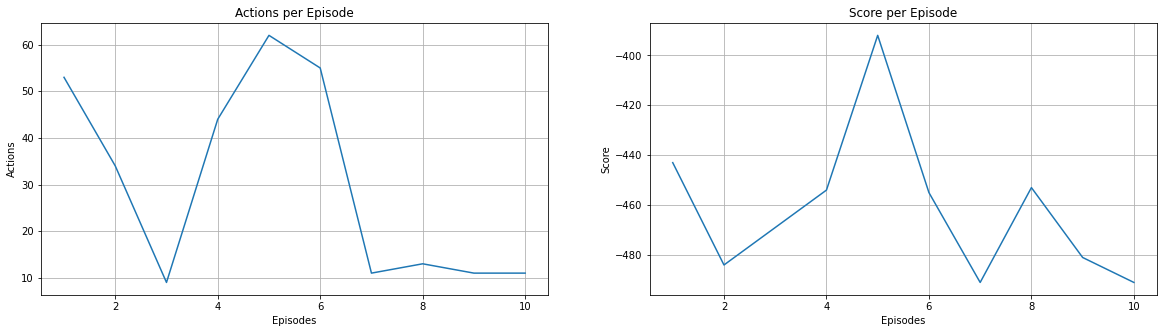

In [41]:
agenteAleatorioS.printResult(kRS)
agenteAleatorioS.winRate(kRS)

In [42]:
agenteAleatorioM = randomPacman()
argsRM = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","mediumClassic"])
argsRM["pacman"] = agenteAleatorioM

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'mediumClassic']


In [43]:
bRM = []
kRM = 10
for i in range(kRM):
    bRM.append(runGames(**argsRM))
    print(bRM[i][0].state.isWin())
    print(bRM[i][0].state.getScore())
    agenteAleatorioM.finish(bRM[i][0].state,i+1)

False
-525.0
Episode: 1; Score = -525.0; Actions = 95
False
-484.0
Episode: 2; Score = -484.0; Actions = 24
False
-484.0
Episode: 3; Score = -484.0; Actions = 64
False
-385.0
Episode: 4; Score = -385.0; Actions = 85
False
-503.0
Episode: 5; Score = -503.0; Actions = 63
False
-391.0
Episode: 6; Score = -391.0; Actions = 131
False
-480.0
Episode: 7; Score = -480.0; Actions = 110
False
-486.0
Episode: 8; Score = -486.0; Actions = 46
False
-461.0
Episode: 9; Score = -461.0; Actions = 21
False
-426.0
Episode: 10; Score = -426.0; Actions = 36


Score average = -462.5
Rate of wins = 0.0%


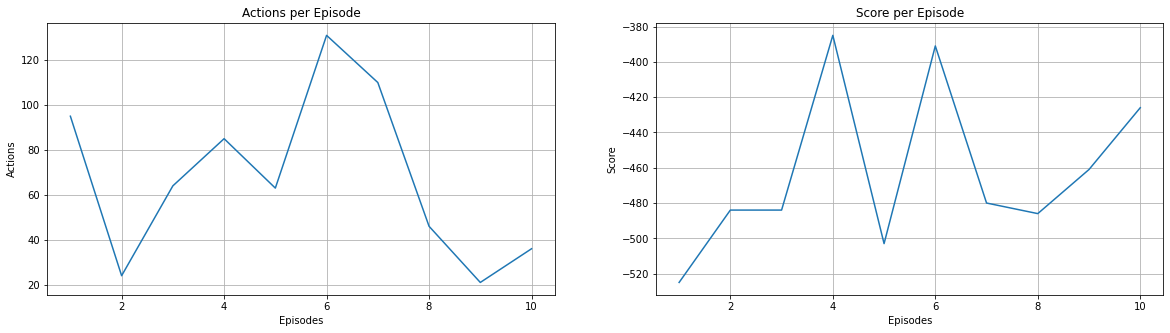

In [44]:
agenteAleatorioM.printResult(kRM)
agenteAleatorioM.winRate(kRM)

In [53]:
agenteAleatorioO = randomPacman()
argsRO = readCommand(["-q","--pacman", "LeftTurnAgent","--layout","originalClassic"])
argsRO["pacman"] = agenteAleatorioO

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'originalClassic']


In [54]:
bRO = []
kRO = 10
for i in range(kRO):
    bRO.append(runGames(**argsRO))
    print(bRO[i][0].state.isWin())
    print(bRO[i][0].state.getScore())
    agenteAleatorioO.finish(bRO[i][0].state,i+1)

False
-540.0
Episode: 1; Score = -540.0; Actions = 270
False
-415.0
Episode: 2; Score = -415.0; Actions = 105
False
-595.0
Episode: 3; Score = -595.0; Actions = 265
False
-481.0
Episode: 4; Score = -481.0; Actions = 111
False
-462.0
Episode: 5; Score = -462.0; Actions = 102
False
-481.0
Episode: 6; Score = -481.0; Actions = 51
False
-676.0
Episode: 7; Score = -676.0; Actions = 376
False
-463.0
Episode: 8; Score = -463.0; Actions = 63
False
-480.0
Episode: 9; Score = -480.0; Actions = 70
False
-412.0
Episode: 10; Score = -412.0; Actions = 82


Score average = -500.5
Rate of wins = 0.0%


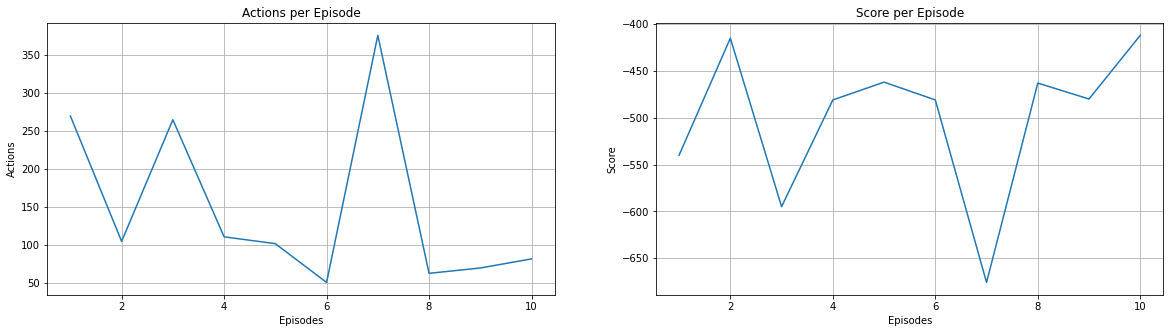

In [55]:
agenteAleatorioO.printResult(kRO)
agenteAleatorioO.winRate(kRO)

Por fim, executamos um agente aleattório para comparar se o algoritmo de aprendizagem por reforço mostrou alguma melhora em relação a jogos aleatórios, para os dois primeiros cenários, ele apresentou de fato resultados melhores, com mais pontos e ações por episódio e pontuação média mais alta, mesmo sem vitórias, o que é o resultado esperado de um algoritmo de aprendizado. Porém, para o layout original, o resultado do modelo aprendiz foi no máximo tão ruim quanto um modelo aleatório, apresentando inclusive menos ações que o modelo aleatório, dependendo da execução, ele também recebe menos pontos e a pontuação média foi pior. Isso é um mau indicador do desempenho do modelo, para cenários grandes ele não está aprendendo bem para cenários muito grandes, mas também pode indicar uma série de erros não identificados na fase de treinamento que pode ter deixado o modelo com mau desempenho. Mais treinamento e uma investigação exaustiva deveria ser feita para incrementar o modelo, porém não será possível realizar no momento por limitações de tempo e hardware.

Parao o aprendizado evolucionário o desempenho foi no geral positivo em relação ao agente aleatório, mesmo no primeiro labirinto com a maioria dos valores negativos o score ainda foi ao menos superior. Nos demais o score médio já ficou muito acima que o aleatório. Um problema evidente no entanto foi uma clara instabilidade no desempenho do algoritmo genético, tendo alguns picos mas uma média de desemepnho não tão interessante

### Conclusão <a name="title21"/>

Um dos pontos mais definitivos sobre o desempenho no algoritmo genético é como foi definida a função de aptidão, como ela foi pensada em alcançar a vitória por meio do consumo de todas as comidas do labirinto. Isso motivou nossos agentes a principalmente fugirem do pacman, algo reforçado pelo agente dos fantasmas no treino ter sido o Direcional, e a não procurar as capsulas. Por conta disso os scores ficaram relativamente baixos e em certos momentos, por não ter fantasmas ou comidas imediatamente próximas e o tempo passado não mudar em nada o score do agente, a ação tomada pelo individuo era ficar parado ou andando em circulos. Um jeito que poderia ter sido utilizado para contornar esse problema era buscando uma nova função de aptidão que levasse o tempo em conta, como por exemple a apresentado no seguinte paper: https://staff.itee.uq.edu.au/marcusg/papers/CEC2003-1432.pdf

Além disso, possivelmente poderia ter sido positivo ter uma taxa de mutabilidade menor, uma vez que com ela resultados maiores foram atingidos mais rapidamente mas pelos gráficos é possível ver uma instabilidade considerável nos resultados. Soma-se aos problemas também um erro cometido na função de treinamento do algortimo genético, pos era vista se a geração parental tinha alcançada a condição de parada de 25% de vitórias por geração mas a que era retornada era a nova população, que poderia não estar a par dos mesmos resultados.

Por fim deve-se considerar também ainda um possível underfit no labirinto original e small do algoritmo genético, uma vez que ambos não atingiram a condição de parada por vitória, somente por geração. Isso se agrava mais no labirinto original uma vez que, devido a grande demora para o seu treinamento e erro cometido durante a execução do mesmo, foi necessário treina-lo apenas em 3 mil gerações.
   